# Milestone 3 - the daTaBABES

This notebook contains our analysis of the data contained in the beer datasets from two websites BeerAdvocate (BA) and RateBeer (RB). The goal of this analysis is to answer the following question:  
**What would be the ideal beer for the US consumer depending on the month?**


In [53]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [54]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

Users have rated the beers from two websites, RateBeer and BeerAdvocate, thus we get reviews of users from two distinct datasets. The reviews are in txt files, thus we convert the txt files into csv so that we can manipulate the data more easily. By doing this, we get as much as data as we can.

The conversion of the txt files into csv files is done in the notebook 'preprocessing_txt.ipynb'.

# Filtering and merging the datasets

## Step 0: Loading the datasets

In [55]:
# Loading the ratings datasets 
ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')
ratings_matched_df = pd.read_csv('data/matched_beer_data/ratings.csv')

# Loading the users dataset 
users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')
users_matched_df = pd.read_csv('data/matched_beer_data/users.csv')

# Loading the beers dataset
beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')
beers_matched_df = pd.read_csv('data/matched_beer_data/beers.csv')

In [56]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

In [57]:
# Create a year_month column
ratings_ba_df['year_month'] = ratings_ba_df['year'].astype(str) + '-' + ratings_ba_df['month'].astype(str)
ratings_rb_df['year_month'] = ratings_rb_df['year'].astype(str) + '-' + ratings_rb_df['month'].astype(str)

# Convert the year_month column to datetime format
ratings_ba_df['year_month'] = pd.to_datetime(ratings_ba_df['year_month'])
ratings_rb_df['year_month'] = pd.to_datetime(ratings_rb_df['year_month'])


In [58]:
# Create copy of original datasets
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()
beers_ba_df_untouched = beers_ba_df.copy()
beers_rb_df_untouched = beers_rb_df.copy()

In [59]:
# Print the number of ratings in each dataset
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2715712
Number of ratings in RateBeer: 7122074


Names of brewery id don't match for both datasets:

In [60]:
beers_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,scores,scores.1
0,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id,brewery_name,nbr_matched_valid_ratings,nbr_ratings,overall_score,style,style_score,zscore,diff,sim
1,4.8,3.45,3.439866666666666,3.504067796610169,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.69830388113311,1.0,1.0


Names of beer styles don't match for both datasets:

In [61]:
ratings_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.6,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,rb.15
0,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel


In [62]:
# print column name and first row to get the real column name
for col in beers_matched_df.columns:
    print(beers_matched_df[col].head(1))
    print('-----------------------')

0    abv
Name: ba, dtype: object
-----------------------
0    avg
Name: ba.1, dtype: object
-----------------------
0    avg_computed
Name: ba.2, dtype: object
-----------------------
0    avg_matched_valid_ratings
Name: ba.3, dtype: object
-----------------------
0    ba_score
Name: ba.4, dtype: object
-----------------------
0    beer_id
Name: ba.5, dtype: object
-----------------------
0    beer_name
Name: ba.6, dtype: object
-----------------------
0    beer_wout_brewery_name
Name: ba.7, dtype: object
-----------------------
0    brewery_id
Name: ba.8, dtype: object
-----------------------
0    brewery_name
Name: ba.9, dtype: object
-----------------------
0    bros_score
Name: ba.10, dtype: object
-----------------------
0    nbr_matched_valid_ratings
Name: ba.11, dtype: object
-----------------------
0    nbr_ratings
Name: ba.12, dtype: object
-----------------------
0    nbr_reviews
Name: ba.13, dtype: object
-----------------------
0    style
Name: ba.14, dtype: object
--------

## Step 1: Only keep ratings from US users

To start our analysis, we look at the distribution of unique users across different countries. We would like to focus on a single country for our analysis as ratings from users from different regions can introduce mixed results that represents no country in reality. For example a certain type of beer can be appreciated in summer and not in winter. But depending on the region of the worls, summer and winter are in different time of the year. So looking at the rating of that beer for each month for each users will not showcase this particularity. By narrowing down to one country, we get a clearer picture of what people in that specific place like. This helps us avoid getting mixed results that might be affected by different tastes and seasons in different parts of the world.

In [63]:
# Extract the country from the location
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

In [64]:
# Number of users per country, in RateBeer
rb_user_count_country = users_rb_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in RateBeer')

# Number of users per country, in BeerAdvocate
ba_user_count_country = users_ba_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in BeerAdvocate')

In [65]:
# Merge the two above data frames to count the total number of users per country
users_country = rb_user_count_country.merge(ba_user_count_country, on='location')
users_country['total nb of users'] = users_country['nb users in RateBeer'] + users_country['nb users in BeerAdvocate']
users_country = users_country.sort_values('total nb of users', ascending=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'England'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Poland'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Germany'),
  Text(8, 0, 'Belgium'),
  Text(9, 0, 'Denmark')])

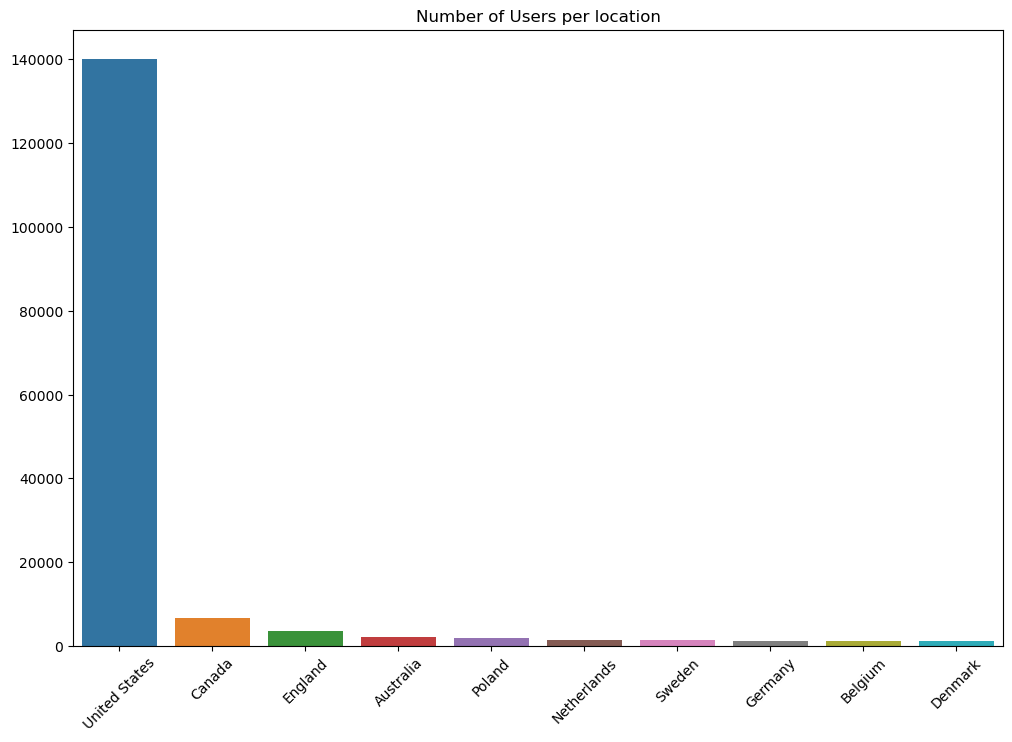

In [66]:
# Plot the distribution of the number of users per country
plt.figure(figsize=(12,8))
sns.barplot(x=users_country['location'].values[:10], y=users_country['total nb of users'].values[:10])
plt.title('Number of Users per location')
plt.xticks(rotation=45)

As we see, the US has much more users than the other countries. This leads us to think that by focusing on this country, we will get the most diverse reviews as they come from many different users. If we would consider Canada for example, we could have bias results as there are not so many users and the reviews come from a small set of people, leading us to provide a perfect beer for very few people. For this reason, our analysis will be focused on the US only.

In [67]:
US_country = 'United States'

# Keep only the rows where the user country is United States
users_ba_df_us = users_ba_df[users_ba_df.location == US_country]
users_rb_df_us = users_rb_df[users_rb_df.location == US_country]

# Keep only the rows where the user country is not from United States
users_ba_df_ca = users_ba_df[users_ba_df.location != US_country]
users_rb_df_ca = users_rb_df[users_rb_df.location != US_country]

In [68]:
# Merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df_us = pd.merge(ratings_ba_df, users_ba_df_us[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_us = pd.merge(ratings_rb_df, users_rb_df_us[['user_id', 'location']], on='user_id', how='inner')

ratings_users_ba_df_ca = pd.merge(ratings_ba_df, users_ba_df_ca[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_ca = pd.merge(ratings_rb_df, users_rb_df_ca[['user_id', 'location']], on='user_id', how='inner')

Filtered dataframe to separate ratings from US users from the rest

In [69]:
# filter the ratings dataframes to only keep ratings of the users from the US
ratings_ba_df_us = ratings_users_ba_df_us[ratings_users_ba_df_us.location == US_country]
ratings_ba_df_us.drop('location', axis=1, inplace=True)
ratings_rb_df_us = ratings_users_rb_df_us[ratings_users_rb_df_us.location == US_country]
ratings_rb_df_us.drop('location', axis=1, inplace=True)

# filter the ratings dataframes to only keep ratings of the users not from US
ratings_ba_df_ca = ratings_users_ba_df_ca[ratings_users_ba_df_ca.location != US_country]
ratings_ba_df_ca.drop('location', axis=1, inplace=True)
ratings_rb_df_ca = ratings_users_rb_df_ca[ratings_users_rb_df_ca.location != US_country]
ratings_rb_df_ca.drop('location', axis=1, inplace=True)


Number of ratings from the US in BeerAdvocate: 2346494
Number of ratings from the US in Ratebeer: 3108958
Number of ratings not from US in BeerAdvocate: 369218
Number of ratings not from US in Ratebeer: 4014825


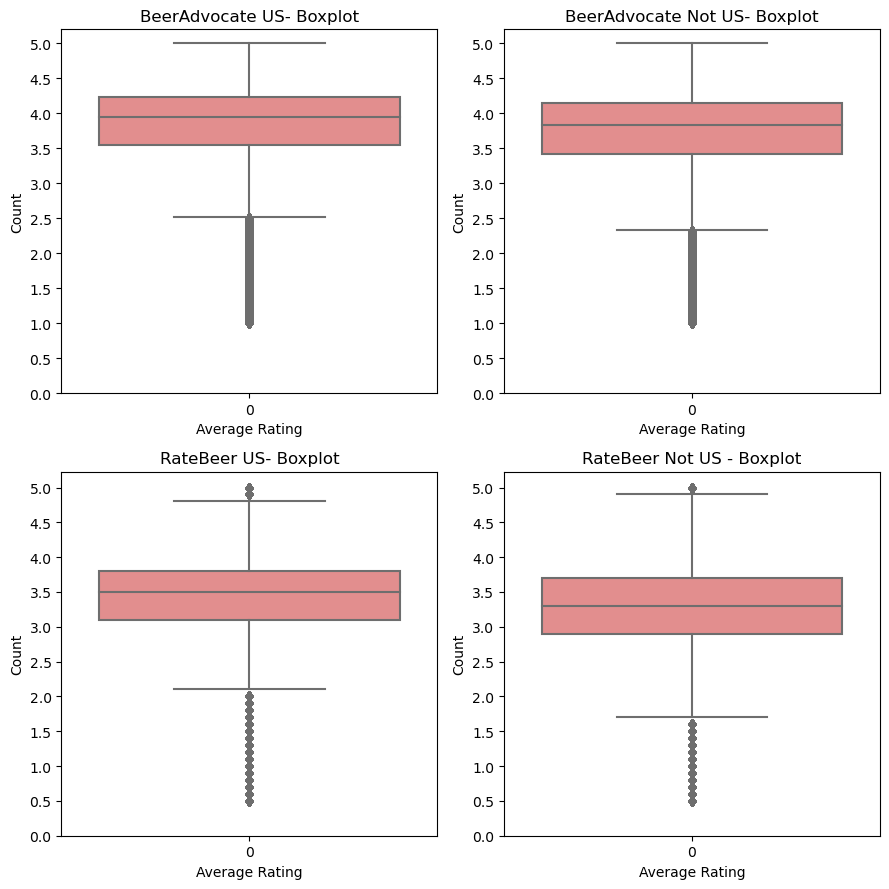

In [70]:
# Plot the distribution of the number of ratings per user
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of ratings from the US in BeerAdvocate:", len(ratings_ba_df_us))
print("Number of ratings from the US in Ratebeer:", len(ratings_rb_df_us))
print("Number of ratings not from US in BeerAdvocate:", len(ratings_ba_df_ca))
print("Number of ratings not from US in Ratebeer:", len(ratings_rb_df_ca))

# BeerAdvocate US- Boxplot
sns.boxplot(ratings_ba_df_us['rating'], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('BeerAdvocate US- Boxplot')
axes[0, 0].set_yticks(np.arange(0, 5.5, 0.5))

# BeerAdvocate Not US- Boxplot
sns.boxplot(ratings_ba_df_ca['rating'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('BeerAdvocate Not US- Boxplot')
axes[0, 1].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer US- Boxplot
sns.boxplot(ratings_rb_df_us['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('RateBeer US- Boxplot')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer Not US - Boxplot
sns.boxplot(ratings_rb_df_ca['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('RateBeer Not US - Boxplot')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

As we can see from the boxplots above, the distribution of the ratings from the users from the US and the others are close for both datasets, but with the average rating being slightly higher when ratings come from US users.  
This means that removing users not from the US won't change the general ratings distribution much and that filtering on good ratings before or after filtering on the users location does not have a big impact on the overall rating distribution. 

Filter the datasets to only keep users from the US:

In [71]:
ratings_ba_df = ratings_ba_df_us
ratings_rb_df = ratings_rb_df_us

In [72]:
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2346494
Number of ratings in RateBeer: 3108958


### Are there users who excessively rate a beer in a short time period ?

Motivation: we want to handle the cases where we could have many ratings from a specific user for the same beer as it could be a user that is trying to bias the rating of a particular beer

In [73]:
# Assuming ratings_combined_df is your DataFrame
threshold = 3  # Adjust this threshold based on your criteria

# Group by user_id, beer_id, and year_month, and count the number of ratings
user_beer_counts_ba = ratings_ba_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')
user_beer_counts_rb = ratings_rb_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')

# Filter for instances where the rating count exceeds the threshold
excessive_ratings_ba = user_beer_counts_ba[user_beer_counts_ba['rating_count'] > threshold]
excessive_ratings_rb = user_beer_counts_rb[user_beer_counts_rb['rating_count'] > threshold]

print("Excessive ratings for BeerAdvocate:")
print(excessive_ratings_ba)
print("Excessive ratings for RateBeer:")
print(excessive_ratings_rb)

Excessive ratings for BeerAdvocate:
Empty DataFrame
Columns: [user_id, beer_id, year_month, rating_count]
Index: []
Excessive ratings for RateBeer:
         user_id  beer_id year_month  rating_count
184060      3070      252 2002-11-01             5
184061      3070      403 2002-01-01             5
184062      3070      411 2002-01-01             5
184063      3070      474 2002-01-01             5
184064      3070      707 2002-01-01             5
1474422    46797       46 2007-01-01            41
1474423    46797       86 2007-03-01            41
1474424    46797       87 2007-01-01            41
1474425    46797      145 2007-01-01            41
1474426    46797      589 2007-02-01            41
1474427    46797      594 2007-02-01            41
1474428    46797      662 2007-03-01            41
1474429    46797      663 2007-03-01            41
1474430    46797      690 2007-01-01            41
1474431    46797      714 2007-01-01            41
1474432    46797      745 2007-02-01

We decided to set the threshold to 3 as rating a same beer more than 3 times per month can seem suspicious. We have identified two users in RateBeer who rated the same beer excessively within a specific month. For example, user 46797 has rated 41 times many beers each month from december 2006 to march 2007.  
Such behavior is suspicious, and as a precautionary measure, we've decided to remove these users from the dataset to keep the reliability of the ratings.

In [74]:
# Remove the suspicious users
users_to_remove = [46797, 3070]
ratings_combined_df = ratings_ba_df[~ratings_ba_df['user_id'].isin(users_to_remove)]


## Step 2: What is a popular beer ?

**Popularity definition:** By popular we mean with respect to the number of **good** reviews


#### Distribution of the average rating in BeerAdvocate

In [75]:
ratings_ba_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.346494e+06
mean,3.900441e+00,3.811440e+00,3.817201e+00,3.854748e+00,3.862540e+00,3.846907e+00
std,5.870042e-01,6.626348e-01,6.496978e-01,6.964354e-01,6.714755e-01,6.044712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.550000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.950000e+00
75%,4.250000e+00,4.250000e+00,4.250000e+00,4.500000e+00,4.250000e+00,4.240000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


#### Distribution of the average rating in RateBeer

In [76]:
ratings_rb_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06
mean,3.536766e+00,6.581593e+00,3.381866e+00,6.651427e+00,1.364188e+01,3.379354e+00
std,7.864937e-01,1.540261e+00,8.069702e-01,1.529019e+00,3.127803e+00,6.799184e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00,1.200000e+01,3.100000e+00
50%,4.000000e+00,7.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,3.500000e+00
75%,4.000000e+00,8.000000e+00,4.000000e+00,8.000000e+00,1.600000e+01,3.800000e+00
max,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01,2.000000e+01,5.000000e+00


Number of beers in BeerAdvocate: 2346494
Number of beers in RateBeer: 3108958


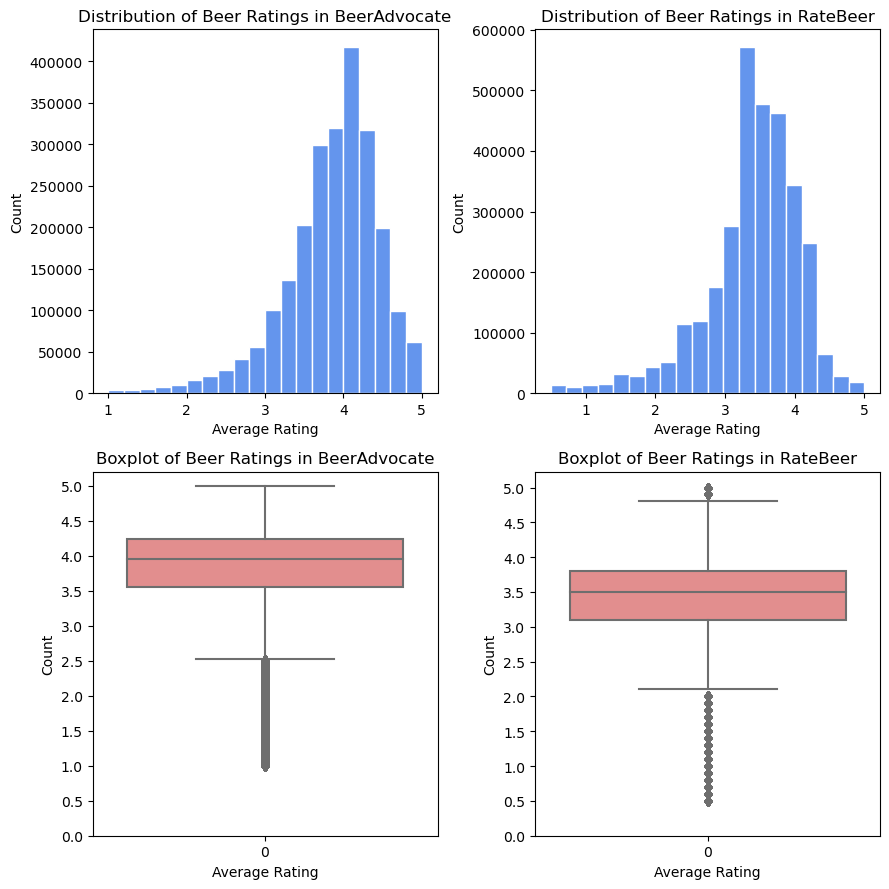

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of beers in BeerAdvocate:", len(ratings_ba_df))
print("Number of beers in RateBeer:", len(ratings_rb_df))

# BeerAdvocate - Histogram
axes[0, 0].hist(ratings_ba_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Beer Ratings in BeerAdvocate')

# RateBeer - Histogram
axes[0, 1].hist(ratings_rb_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Beer Ratings in RateBeer')
axes[0, 1].ticklabel_format(style="plain", axis="y")

# BeerAdvocate - Boxplot
sns.boxplot(ratings_ba_df['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Boxplot of Beer Ratings in BeerAdvocate')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer - Boxplot
sns.boxplot(ratings_rb_df['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Boxplot of Beer Ratings in RateBeer')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

In [78]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


As observed from the tables and the plot above, even though the distributions have a similar shape, i.e. normal distribution, they have a different average mean ratings. Indeed, users from the RateBeer dataset seem to be harsher in their ratings.

Now, as defined above, our popularity definition concerns the number of good ratings. A question that arises is: what can be considered as a good rating?

The ratings are continuous numbers between 0 to 5. One idea is to keep the ratings above the average mean of the two datasets and consider them as good rating. With this, we take in account the different distribution of the ratings into the two datasets and find a relatively good threshold.

Let's see what are the 10 most rated beer styles in each dataset:

Number of Beer Styles in AdvocateBeer: 104
Number of Beer Styles in RateBeer: 90


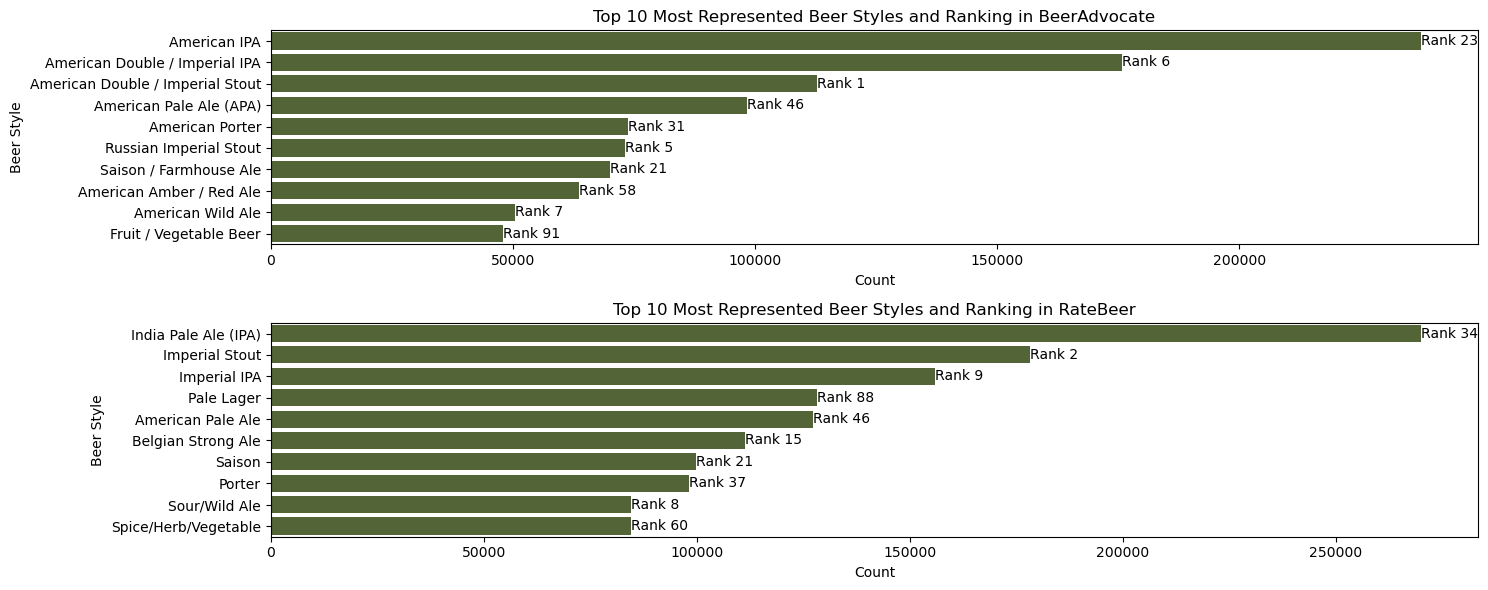

In [79]:
top_ratings_by_style_ba = ratings_ba_df.groupby('style')['rating'].mean().sort_values(ascending=False)
top_ratings_by_style_rb = ratings_rb_df.groupby('style')['rating'].mean().sort_values(ascending=False)

print(f"Number of Beer Styles in AdvocateBeer: {len(top_ratings_by_style_ba)}")
print(f"Number of Beer Styles in RateBeer: {len(top_ratings_by_style_rb)}")

# Number of top beer styles to plot
x = 10

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# BeerAdvocate
plot1 = sns.countplot(y='style', data=ratings_ba_df, order=ratings_ba_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[0])
for i, style in enumerate(ratings_ba_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_ba.index.get_loc(style) + 1  
    plot1.text(ratings_ba_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Beer Style')
axes[0].set_title(f'Top {x} Most Represented Beer Styles and Ranking in BeerAdvocate')

# RateBeer
plot2 = sns.countplot(y='style', data=ratings_rb_df, order=ratings_rb_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[1])
for i, style in enumerate(ratings_rb_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_rb.index.get_loc(style) + 1  
    plot2.text(ratings_rb_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Beer Style')
axes[1].set_title(f'Top {x} Most Represented Beer Styles and Ranking in RateBeer')

plt.tight_layout()
plt.show()

From the two plots above we can observe that a beer style can be popular but not have the best rating. For example in the plot of the RateBeer dataset, we see that the 3rd most popular beer style with respect to “count” is the 91th most popular beer style (over 93) when it comes to mean average rating. This finding conforts us in our definition of popularity.

We don't need to filter the datasets on popular ratings since, as we will see later in the analysis, we use the lower bound of Wilson score to rank beers.

In [80]:
# Create dataframes with only the popular ratings
ratings_ba_df_good = ratings_ba_df[ratings_ba_df['rating'] > mean_ba]
ratings_rb_df_good = ratings_rb_df[ratings_rb_df['rating'] > mean_rb]


In [81]:
nbr_ratings_ba = ratings_ba_df_good.shape[0]
nbr_ratings_rb = ratings_rb_df_good.shape[0]

print('Number of good ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of good ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of good ratings in BeerAdvocate: 1358021
Number of good ratings in RateBeer: 1863770


## Step 3: Names have to match between the two datasets

Motivation: We noticed that beer styles names vary across the two datasets and we want them to match to be able to process the data correctly.

In the matched beer dataset, we only have a limited subset of the entire datasets. Consequently, if we aim to replace the style names of beers in the matched dataset using beer_id, we will only have matching names for a small fraction of all the beers in the datasets. Therefore, we will base our conversion on the beer style.

In [82]:
beer_ids_ba_not_matched = beers_ba_df['beer_id'][~beers_ba_df['beer_id'].isin(beers_matched_df['ba.5'])]
print(f'Percentage of beers in BeerAdvocate not in the matched dataset: {len(beer_ids_ba_not_matched) / beers_ba_df.shape[0] * 100}')

beer_ids_rb_not_matched = beers_rb_df['beer_id'][~beers_rb_df['beer_id'].isin(beers_matched_df['rb.4'])]
print(f'Percentage of beers in RateBeer not in the matched dataset: {len(beer_ids_rb_not_matched) / beers_rb_df.shape[0] * 100}')

Percentage of beers in BeerAdvocate not in the matched dataset: 89.58169380713117
Percentage of beers in RateBeer not in the matched dataset: 93.38198203496644


All 104 different styles present in AdvocateBeer are also in the matched dataset while 80 out of the 90 styles in RateBeer are in the matched dataset:

In [83]:
# Number of styles in BA and RB in matched dataset
total_groups = len(beers_matched_df[1:].groupby('ba.14'))
print(f'Total number of styles in BA in matched dataset: {total_groups}')

total_groups = len(beers_matched_df[1:].groupby('rb.12'))
print(f'Total number of styles in RB in matched dataset: {total_groups}')

Total number of styles in BA in matched dataset: 104
Total number of styles in RB in matched dataset: 80


We observe that the number of beer styles in RateBeer is smaller than that in BeerAdvocate, and each style in the latter is present in the matched dataset. Moreover, RateBeer has slightly more ratings compared to BeerAdvocate. Due to these findings, we have opted to match the style names in BeerAdvocate with their corresponding names in RateBeer.   
As part of this conversion process, we decided to merge some styles in AdvocateBeer to adopt the broader style names used in RateBeer. This allows us to maintain consistency in the nuances used to specify the style of a beer.  While this may result in a loss of some specific distinctions present in BeerAdvocate, such as the differentiation between American and English Barleywine styles, it ensures a more uniform representation of beer styles across both datasets. In our example, it allows us to have all corresponding beers under one style "Barleywine" instead of three different styles "Barleywine", "English Barleywine", and "American Barleywine".

In [84]:
# For each style in BA, show the most used corresponding style name in RB
style_ba_to_rb_dict = {}
for style1, group_style2 in beers_matched_df[1:].groupby('ba.14'):
    styles2_counts = group_style2['rb.12'].value_counts().head(5)
    print(f'{style1} --> {styles2_counts}')
    style_ba_to_rb_dict[style1] = styles2_counts.index[0]
    print('-----------------------')


Altbier --> rb.12
Altbier              203
Amber Ale              7
Traditional Ale        4
Sour/Wild Ale          2
American Pale Ale      1
Name: count, dtype: int64
-----------------------
American Adjunct Lager --> rb.12
Pale Lager            78
Premium Lager         17
Pilsener              11
Specialty Grain        4
Amber Lager/Vienna     4
Name: count, dtype: int64
-----------------------
American Amber / Red Ale --> rb.12
Amber Ale               932
American Strong Ale     117
India Pale Ale (IPA)     60
Irish Ale                48
Spice/Herb/Vegetable     27
Name: count, dtype: int64
-----------------------
American Amber / Red Lager --> rb.12
Amber Lager/Vienna    61
Amber Ale             14
Premium Lager         10
Pale Lager             4
Dunkel/Tmavý           3
Name: count, dtype: int64
-----------------------
American Barleywine --> rb.12
Barley Wine             291
American Strong Ale       3
Spice/Herb/Vegetable      2
Imperial IPA              2
Abt/Quadrupel       

After reviewing all the matches, we have updated the dictionary for some beer styles that have a better match. Additionally, we have removed styles from the dictionary that lack a good corresponding match.  As mentionned before, almost all beer styles in BA are more specific than in RB (hence the matching done from BA to RB)However, there is an exception: in BA, there is a "Fruit / Vegetable Beer" and "Herbed / Spiced Beer" stylew, while in RB, we have separate styles for "Fruit Beer" and "Spice/Herb/Vegetable" beers. To maintain consistency, we have decided to match them all to a new style "Fruit/Vegetable/Spice/Herb".   
All the details of the conversion can be found [here](https://docs.google.com/document/d/1N-4J1bIBUBweYRB572MTSPa1Gt0a5SRAkFFuJLWNB08/edit?usp=sharing).

We obtain the following beer style conversion dictionnary:

In [85]:
#Dictionnary to convert some styles in RB 
style_rb_convert_dict = {}
style_rb_convert_dict['Fruit Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_rb_convert_dict['Spice/Herb/Vegetable'] = 'Fruit/Vegetable/Spice/Herb'

#Change the styles in BA that can have a better match in RB
style_ba_to_rb_dict['English Pale Ale'] = 'English Pale Ale'
style_ba_to_rb_dict['Czech Pilsener'] = 'Czech Pilsner (Světlý)'
style_ba_to_rb_dict['Herbed / Spiced Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_ba_to_rb_dict['Fruit / Vegetable Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_ba_to_rb_dict['Pumpkin Ale'] = 'Fruit/Vegetable/Spice/Herb'

#Remove the styles in BA that don't have a corresponding style in RB
style_ba_to_rb_dict.pop('American Adjunct Lager')
style_ba_to_rb_dict.pop('Euro Dark Lager')
style_ba_to_rb_dict.pop('Euro Strong Lager')
style_ba_to_rb_dict.pop('Oatmeal Stout')
style_ba_to_rb_dict.pop('Roggenbier')
style_ba_to_rb_dict.pop('Rye Beer')
style_ba_to_rb_dict.pop('Bock')
style_ba_to_rb_dict.pop('Light Lager')
style_ba_to_rb_dict.pop('Kvass')
style_ba_to_rb_dict.pop('Scottish Gruit / Ancient Herbed Ale')
style_ba_to_rb_dict.pop('Wheatwine')
style_ba_to_rb_dict.pop('Winter Warmer')
style_ba_to_rb_dict.pop('Bière de Champagne / Bière Brut')
style_ba_to_rb_dict.pop('Black & Tan')
style_ba_to_rb_dict.pop('Happoshu')
style_ba_to_rb_dict.pop('Japanese Rice Lager')
style_ba_to_rb_dict.pop('Chile Beer')

'Spice/Herb/Vegetable'

In [86]:
style_ba_to_rb_dict

{'Altbier': 'Altbier',
 'American Amber / Red Ale': 'Amber Ale',
 'American Amber / Red Lager': 'Amber Lager/Vienna',
 'American Barleywine': 'Barley Wine',
 'American Black Ale': 'Black IPA',
 'American Blonde Ale': 'Golden Ale/Blond Ale',
 'American Brown Ale': 'Brown Ale',
 'American Dark Wheat Ale': 'Wheat Ale',
 'American Double / Imperial IPA': 'Imperial IPA',
 'American Double / Imperial Pilsner': 'Imperial Pils/Strong Pale Lager',
 'American Double / Imperial Stout': 'Imperial Stout',
 'American IPA': 'India Pale Ale (IPA)',
 'American Malt Liquor': 'Malt Liquor',
 'American Pale Ale (APA)': 'American Pale Ale',
 'American Pale Lager': 'Pale Lager',
 'American Pale Wheat Ale': 'Wheat Ale',
 'American Porter': 'Porter',
 'American Stout': 'Stout',
 'American Strong Ale': 'American Strong Ale ',
 'American Wild Ale': 'Sour/Wild Ale',
 'Baltic Porter': 'Baltic Porter',
 'Belgian Dark Ale': 'Belgian Ale',
 'Belgian IPA': 'India Pale Ale (IPA)',
 'Belgian Pale Ale': 'Belgian Ale',
 

In [87]:
style_rb_convert_dict

{'Fruit Beer': 'Fruit/Vegetable/Spice/Herb',
 'Spice/Herb/Vegetable': 'Fruit/Vegetable/Spice/Herb'}

Convert the name of beer styles in the RateBeer beers and ratings datasets:

In [88]:
ratings_ba_df['style'] = ratings_ba_df['style'].replace(style_ba_to_rb_dict)
ratings_rb_df['style'] = ratings_rb_df['style'].replace(style_rb_convert_dict)

beers_ba_df['style'] = beers_ba_df['style'].replace(style_ba_to_rb_dict)
beers_rb_df['style'] = beers_rb_df['style'].replace(style_rb_convert_dict)

### Step 4: Merge the rating datasets from BeerAdvocate and RateBeer

In [89]:
# Add column 'dataset' to the datasets to know where each row comes from orignally
ratings_ba_df['dataset'] = 'BeerAdvocate'
ratings_rb_df['dataset'] = 'RateBeer'
beers_ba_df['dataset'] = 'BeerAdvocate'
beers_rb_df['dataset'] = 'RateBeer'

# merge the two ratings dataframes
ratings_combined_df_untouched = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# merge the two beers dataframes
beers_combined_df_untouched = pd.concat([beers_ba_df_untouched, beers_rb_df_untouched], ignore_index=True)
beers_combined_df = pd.concat([beers_ba_df, beers_rb_df], ignore_index=True)


# Temporal Analysis

## General Analysis

In [90]:
# Group by year_month and count the number of ratings per year_month
year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()

print('Earliest date of ratings:', ratings_combined_df['date'].min())
print('Latest date of ratings:', ratings_combined_df['date'].max())

Earliest date of ratings: 1996-08-22 10:00:00
Latest date of ratings: 2017-08-01 10:00:00


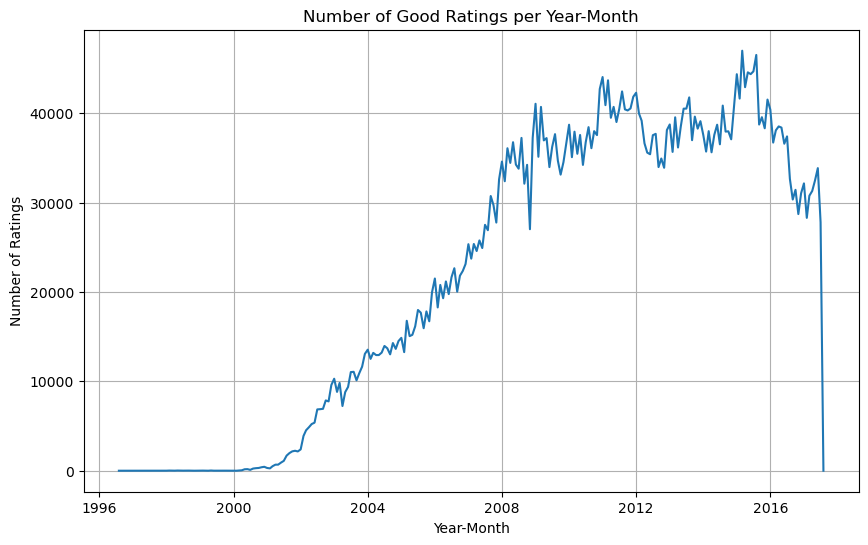

In [91]:
# Yearly plot of the number of ratings
plt.figure(figsize=(10, 6))
plt.plot(year_month_ratings_count)
plt.title('Number of Good Ratings per Year-Month')
plt.xlabel('Year-Month')
plt.grid()
plt.ylabel('Number of Ratings')
plt.show()

By observing the plot, the number of ratings increases linearly from 1996 to 2008. After 2008, it still increases but less. Also, we observe a lot of variations, especially between 2008 and 2016, which could indicate a seasonality of the beers.

Let's observe the average ratings per month from 2008 to 2016.

In [92]:
# Create a new dataframe with the number of ratings per year_month
year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

# Create column year and month
year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

# Keep only rows where the year is greater than 2011 and less than 2017 
year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= 2008) & (year_month_ratings_count_df.year < 2017)]

# Compute the mean number of ratings per month
mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

# Plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings.

In [93]:
# Create a new dataframe with the number of ratings per year_month
year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

# Create column year and month
year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

# Keep only rows where the year is greater than 2011 and less than 2017 
year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year > 2011) & (year_month_ratings_count_df.year < 2017)]

# Compute the mean number of ratings per month
mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

# Plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2012 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

By narrowing the filtering of the years, we observe with the Mean Number of Ratings curve, that the peaks are more intense, especially for August and October.

## Top Beer Styles per Month

Number of unique beer styles: 107 



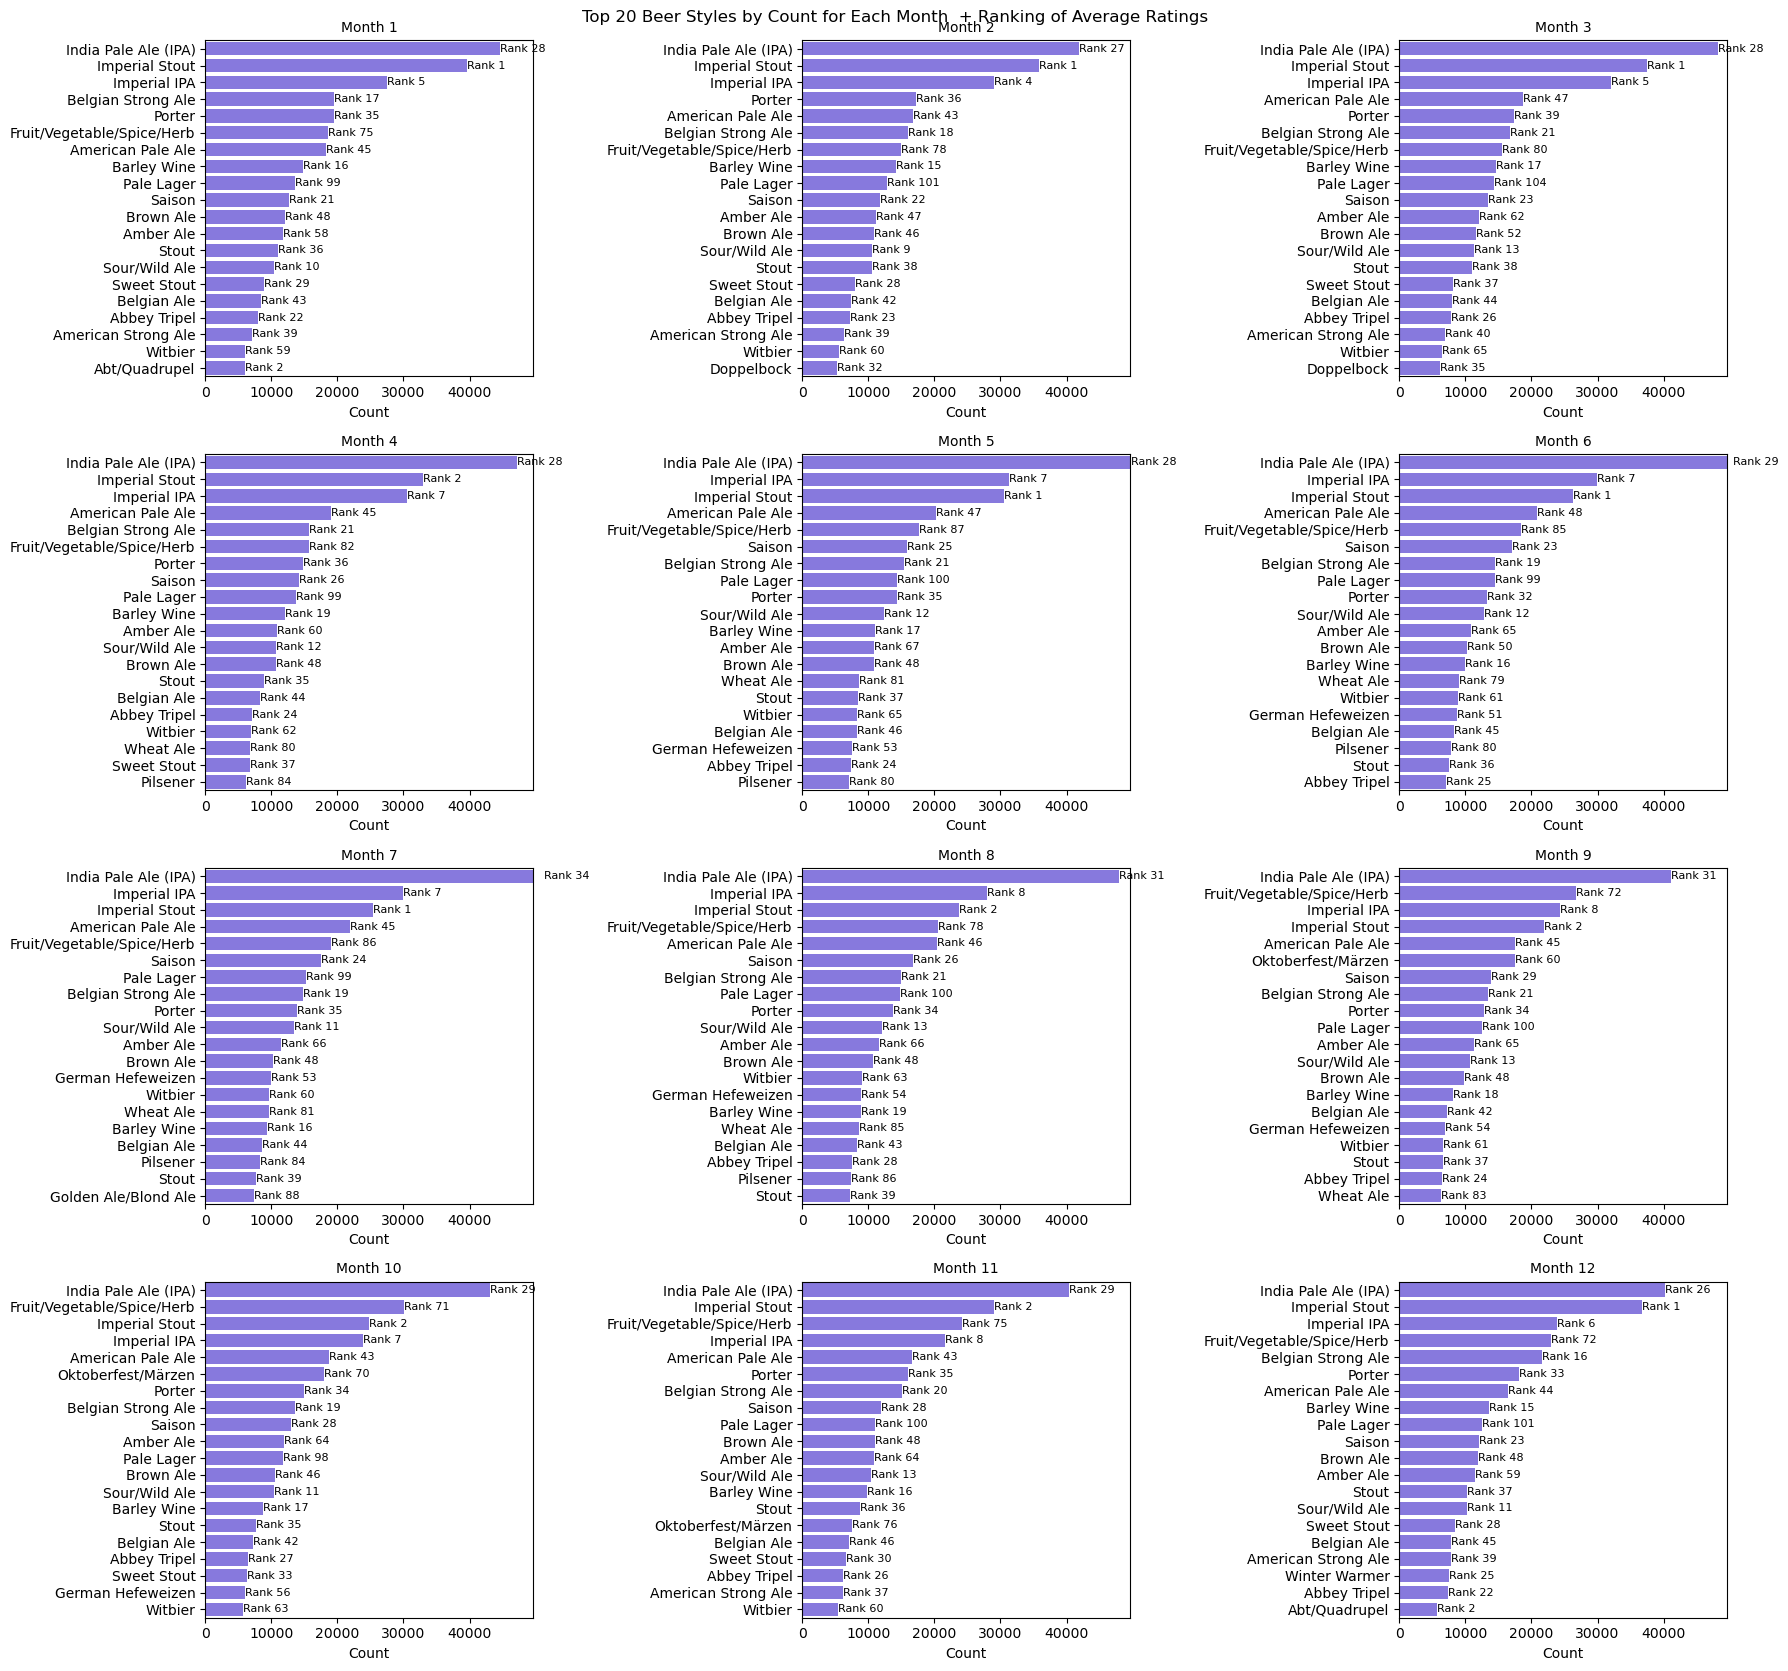

Number of styles that appear in the top 20 for at least one month: 
 27
Style Occurrences:
Abbey Tripel: 11 times
Abt/Quadrupel: 2 times
Amber Ale: 12 times
American Pale Ale: 12 times
American Strong Ale: 5 times
Barley Wine: 12 times
Belgian Ale: 12 times
Belgian Strong Ale: 12 times
Brown Ale: 12 times
Doppelbock: 2 times
Fruit/Vegetable/Spice/Herb: 12 times
German Hefeweizen: 6 times
Golden Ale/Blond Ale: 1 times
Imperial IPA: 12 times
Imperial Stout: 12 times
India Pale Ale (IPA): 12 times
Oktoberfest/Märzen: 3 times
Pale Lager: 12 times
Pilsener: 5 times
Porter: 12 times
Saison: 12 times
Sour/Wild Ale: 12 times
Stout: 12 times
Sweet Stout: 7 times
Wheat Ale: 6 times
Winter Warmer: 1 times
Witbier: 11 times


In [95]:
unique_styles = sorted(ratings_combined_df['style'].unique())
print(f'Number of unique beer styles: {len(unique_styles)} \n')

# Number of top beer styles to plot
x = 20

fig, axes = plt.subplots(4, 3, figsize=(18, 17))
fig.suptitle(f'Top {x} Beer Styles by Count for Each Month  + Ranking of Average Ratings')

max_count_across_months = ratings_combined_df.groupby('month')['style'].value_counts().head(x).max()
style_occurrences = {style: 0 for style in unique_styles}

for month, ax in zip(range(1, 13), axes.flatten()):
    month_data = ratings_combined_df[ratings_combined_df['month'] == month]
    top_styles_by_count = month_data['style'].value_counts().head(x).index
    avg_ratings_by_style = month_data.groupby('style')['rating'].mean().sort_values(ascending=False)

    # Count the number of times each style appears in the top 20 for each month
    for style in top_styles_by_count:
        style_occurrences[style] += 1

    sns.countplot(y='style', data=month_data, order=top_styles_by_count, ax=ax, color='mediumslateblue')
    ax.set_title(f'Month {month}', fontsize=10)
    ax.set_xlabel('Count')
    ax.set_ylabel('')
    ax.set_xlim(0, max_count_across_months + 5000)
    for i, style in enumerate(top_styles_by_count):
        ranking = avg_ratings_by_style.index.get_loc(style) + 1
        ax.text(month_data['style'].value_counts()[i], i, f'Rank {ranking}', va='center', ha='left', color='black', fontsize=8)

plt.tight_layout()
plt.show()

# Print the style occurrences dictionary and remove styles that never appear in the top 20
style_occurrences = {style: count for style, count in style_occurrences.items() if count > 0}
print("Number of styles that appear in the top 20 for at least one month: \n", len(style_occurrences))
print("Style Occurrences:")
for style, count in style_occurrences.items():
    print(f"{style}: {count} times")

Let's now observe the average ratings per month of some Beer's style. Can we see any particular differences? Have those styles any period where the number of ratings increases?

In [104]:
sample_styles = ['Oktoberfest/Märzen', 'American Pale Ale', 'Fruit/Vegetable/Spice/Herb']

for style in sample_styles: 
    ratings_users_sample = ratings_combined_df[ratings_combined_df['style'] == style]

    # Group by year_month and count the number of ratings per year_month
    year_month_ratings_count_sample = ratings_users_sample.groupby('year_month')['year_month'].count()

    year_month_ratings_count_sample = pd.DataFrame({'year_month': year_month_ratings_count_sample.index, 'nbr_ratings': year_month_ratings_count_sample.values})

    year_month_ratings_count_sample['year'] = year_month_ratings_count_sample['year_month'].dt.year
    year_month_ratings_count_sample['month'] = year_month_ratings_count_sample['year_month'].dt.month

    # Keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_sample[(year_month_ratings_count_sample.year >= 2008) & (year_month_ratings_count_sample.year < 2017)]

    # Compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    # Plot with plotly the mean number of ratings per month
    fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month for {}'.format(style))
    fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

    fig.show()

From the three plots, we observe big differences of the average ratings over a year. The 'Oktoberfest/Märzen' style of beers has a big increases of the ratings during the Oktoberfest period, in October. During the rest of the year, the number of ratings is low and does not fluctuates at all.

One of the most rated style is the APA, and as observed in the plot, the number of ratings does not have huge increases at some period. The style is quite popular throughout the year.

Finally, the style 'Belgian Dark Ale' has a huge increase of the number of good ratings at the end of the year, during the festivities of the end of the year.

## Dictionary Analysis

In order to analyze the reviews of users, we create dictionaries that contain key words that are commonly used to describe some aspects of a beer. From these dictionaries, we look for the keywords in the reviews and we will then analyze more in depth wether it is used with in a positive or negative way. At the end of this part, we should be able to get the best aroma, taste, palate, and other perfect beer caracteristics for each month.

First, let's define our dictionaries and look wether they are relevant or not by looking at the distribution of key words in the reviews.

In [105]:
# Key words taken from https://appellationbeer.com/blog/words-to-describe-the-beer-you-are-tasting/

aroma = ('Malty, biscuity, breadlike, grainy, rich, deep, roasty, cereal, cookie-like, coffeeish, caramelly, toffee-like, molasses-like, malt complexity, smoky, sweet, autumnal, burnt cream, scalded milk, oatmeal, rustic, layered'.split(',')) + ('Piney, citrusy, grapefruity, earthy, musty, spicy, sharp, bright, fresh, herbal, zippy, lemony, newly-mown lawn, aromatic, floral, springlike, brilliant, sprucelike, juniper-like, minty, pungent, elegant, grassy'.split(','))
color = 'pale straw, staw, pale gold, deep gold, pale amber, medium amber, deep amber, amber brown, brown, ruby brown, deep brown, black'.split(',')
flavors = 'Sweet, Malty, biscuity, breadlike, grainy, rich, deep, roasty, cereal, cookie-like, coffeeish, caramelly, toffee-like, molasses-like, malt complexity, smoky, autumnal, burnt cream, scalded milk, oatmeal, rustic, layered'.split(',')
flavor_bitterness = 'Piney, citrusy, grapefruity, earthy, musty, spicy, sharp, bright, fresh, herbal, zippy, lemony, newly-mown lawn, aromatic, floral, springlike, brilliant, sprucelike, juniper-like, minty, pungent, elegant, grassy'.split(',')
fermentation_taste = 'Fresh-baked bread, clovelike, bubblegum, yeasty, Belgiany, aromatic, tropical, subtle, fruity, clean, banana-like, horseblankety, earthy, musty'.split(',')
conditioning = 'Soft, effervescent, spritzy, sparkling, zippy, pinpoint, bubbly, gentle, low carbonation, highly carbonated'.split(',')
body_mouthfeel = 'Rich, full, light, slick, creamy, oily, heavy, velvety, dry, thick, thin'.split(',')
alcohol_flavors = 'Warm finish, heat, vodka, esters, pungent, strength'.split(',')

In [106]:
# Creates dict from lists

flavors_dict = {x:0 for x in flavors}
flavor_bitterness_dict = {x:0 for x in flavor_bitterness}
fermentation_taste_dict = {x:0 for x in fermentation_taste}
conditioning_dict = {x:0 for x in conditioning}
body_mouthfeel_dict = {x:0 for x in body_mouthfeel}
alcohol_flavors_dict = {x:0 for x in alcohol_flavors}
aroma_dict = {x:0 for x in aroma}
color_dict = {x:0 for x in color}

In [107]:
# Lists of dictionaries and categories, used after to count the occurences.

key_words_lists = [flavors, flavor_bitterness, fermentation_taste, conditioning, body_mouthfeel, alcohol_flavors, aroma, color]
key_words_dict = [flavors_dict, flavor_bitterness_dict, fermentation_taste_dict, conditioning_dict, body_mouthfeel_dict, alcohol_flavors_dict, aroma_dict, color_dict]
categories = 'Flavors, Flavor bitterness, fermentation taste, conditioning, body mouthfeel, alcohol flavors, Aroma, Color'.split(',')

Now, let's retrieve reviews from US users.

In [108]:
us_texts_ba = ratings_ba_df.merge(users_ba_df, on='user_id', how='inner')
us_texts_rb = ratings_rb_df.merge(users_rb_df, on='user_id', how='inner')

In [109]:
# Drop missing text
us_texts_ba = us_texts_ba.dropna(subset=['text'])
us_texts_rb = us_texts_rb.dropna(subset=['text'])

In [110]:
texts = list(us_texts_ba['text'].values) + list(us_texts_rb['text'].values)

We now count the occurences of our key words in the different texts.

In [111]:
for i, ls in enumerate(key_words_lists):
    current_dict = key_words_dict[i]
    
    for w in ls:
        for text in texts:
            if w.lower() in text:
                current_dict[w] += 1

To make the plot clearer, we divide by the total number of reviews. Therefore, in the plot we read the percentage of reviews in which a key word is present.

In [112]:
total_reviews = len(texts)

In [113]:
# Plot the occurences per catefory
for i,d in enumerate(key_words_dict):
    category = categories[i]
    plt.figure(figsize=(20,8))
    sns.barplot(x=d.keys(), y= (np.asarray(list(d.values())) / total_reviews))
    plt.title('Number of occurences of key words for category ' + category)
    plt.xticks(rotation=45)

AttributeError: 'bool' object has no attribute 'all'

<Figure size 2000x800 with 0 Axes>

As we see, in aroma, "sweet" is much more present than the other key words and in color "brown" dominates. Let's remove them to have a better idea of the plot for the other key words.